In [1]:
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
#import mne

# graphical libs
from matplotlib import pyplot as plt
%matplotlib widget

# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ml libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score, classification_report, mean_squared_error
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter, filtfilt, butter

import optuna
from optuna.samplers import TPESampler

# set number of rows ti display
#pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# lib for interpretator processing
import sys, os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Hide output
from IPython.display import clear_output

# Model serialization
import pickle

import serial
import time

In [2]:
# Set requirements
#!pip install -qr ../requirements.txt

In [3]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import add_diff, get_mse, preprocessing_0, preprocessing_1, reset_random_seeds, callbacks
from utils.figures import get_signals_plot, get_signals_comparison_plot, plot_history #get_all_sensors_plot, 

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

# path for models
PATH_MODEL = config.PATH_FOR_MODEL

# if not os.path.exists(PATH_FOR_MODEL):
#     os.mkdir(PATH_FOR_MODEL) 

In [4]:
import random

# Fix seed
seed_value = config.seed_value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. initiate random seed in Python
random.seed(seed_value)

# 2. initiate random seed in Numpy
np.random.seed(seed_value)

# 3. initiate random seed in Optuna
sampler = TPESampler(seed=seed_value) # fix random seed

# 4. initiate random seed in tensorflow 
tf.random.set_seed(seed_value)
 
# 5. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
# Reading files with ".npy" and 'csv' extension and saving them to the dictionnary "mounts"
mounts = dict()

with ZipFile(os.path.join(PATH, 'data.zip')) as myzip:
    for file in myzip.namelist():
            mounts[f"{file[:-4]}".format(file)] = pd.read_csv(myzip.open(file), index_col=0)

mounts.keys()

dict_keys(['gestures_protocol', 'gestures_test', 'gestures_train'])

### Gestures train and test

In [6]:
gestures_train = mounts['gestures_train']

print(gestures_train.shape)
gestures_train.head()

(21320, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,0,0,69,3461,3694,3418,1867,13,7,7,...,-8,13,34,48,35,32,0,0,0,161790
1,0,11,58,3462,3692,3417,1868,13,7,5,...,-1,13,34,48,35,32,0,0,0,161823
2,10,8,51,3463,3693,3418,1870,21,6,6,...,4,13,34,48,35,32,0,0,0,161856
3,11,9,58,3463,3692,3418,1871,13,6,6,...,6,13,34,48,35,32,0,0,0,161889
4,11,8,58,3460,3692,3418,1869,13,6,5,...,7,13,34,48,35,32,0,0,0,161922


In [7]:
gestures_test = mounts['gestures_test']

print(gestures_test.shape)
gestures_test.head()

(5330, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
21320,11,19,46,3206,3821,3710,1780,8,5,5,...,-2,12,22,41,83,42,0,0,173,865350
21321,10,8,53,3169,3812,3527,1664,7,5,5,...,-1,12,22,41,83,42,0,0,173,865383
21322,10,7,43,3127,3806,3351,1556,8,6,5,...,4,12,24,45,87,52,0,0,173,865416
21323,10,8,41,3085,3793,3178,1480,7,8,5,...,1,12,24,46,87,55,0,0,173,865449
21324,10,6,48,3046,3771,3049,1436,8,6,6,...,0,12,25,46,88,57,0,0,173,865482


In [8]:
# Обозначение колонок для удобства доступа
OMG_CH = [str(i) for i in range(50)]

ACC_CH = config.ACC_CH
GYR_CH = config.GYR_CH
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = config.GLOVE_CH[:-1] # Датчик 'ENC5' не используем
#GLOVE_CH = GLOVE_CH
BUTTON_SYNC_TS_CH = config.BUTTON_SYNC_TS_CH

col_diff_names = [x + '_DIFF' for x in OMG_CH]
COLS = OMG_CH + col_diff_names

#assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements.shape[-1]

print(f"OMG_CH: {OMG_CH}")
print(f"ACC_CH: {ACC_CH}")
print(f"GYR_CH: {GYR_CH}")
print(f"GLOVE_CH: {GLOVE_CH}")
print(f"BUTTON_SYNC_TS_CH: {BUTTON_SYNC_TS_CH}")

col_diff_names = [x + '_DIFF' for x in OMG_CH]

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


### Protocol

In [9]:
gestures_protocol = mounts['gestures_protocol']
gestures_protocol.head(11)

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [10]:
gestures_train[ACC_CH].describe()

,ACC0,ACC1,ACC2
count,21320.000000,21320.000000,21320.000000
mean,-22.278940,-19.521951,119.965244
std,22.367186,10.134278,66.628384
min,-79.000000,-54.000000,25.000000
25%,-48.000000,-27.000000,56.000000
50%,-13.000000,-24.000000,91.000000
75%,-7.000000,-11.000000,211.000000
max,45.000000,14.000000,233.000000


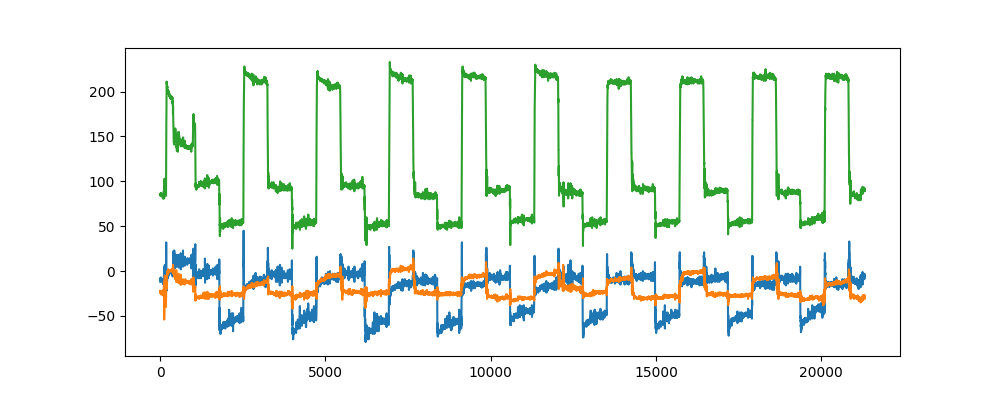

In [11]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 4)) # plt.sca(axes)
plt.plot(gestures_train[ACC_CH])
plt.show()

In [12]:
gestures_train[GYR_CH].describe()

,GYR0,GYR1,GYR2
count,21320.000000,21320.000000,21320.000000
mean,96.091041,-8.444465,-0.755066
std,7.282955,39.610729,6.593200
min,3.000000,-470.000000,-98.000000
25%,95.000000,-11.000000,-2.000000
50%,96.000000,-9.000000,-1.000000
75%,97.000000,-6.000000,0.000000
max,185.000000,696.000000,91.000000


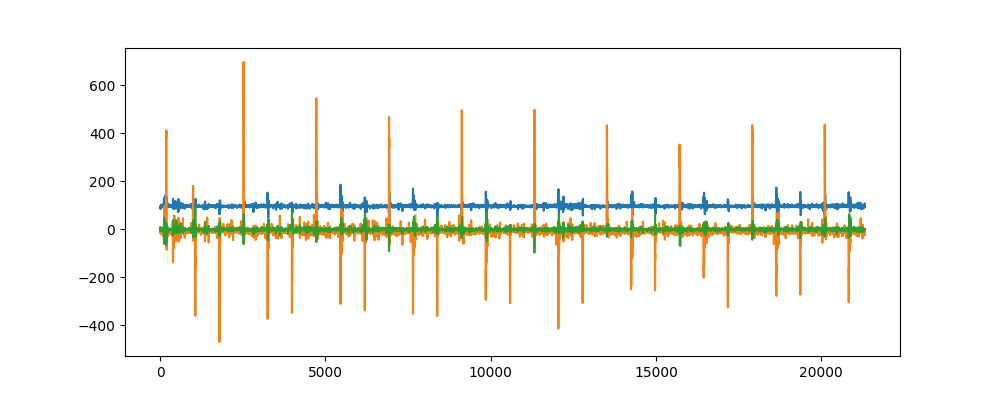

In [13]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 4)) # plt.sca(axes)
plt.plot(gestures_train[GYR_CH])
plt.show()

In [14]:
gestures_protocol[['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']].values - np.arange(5) * 2

array([[ 0., -2., -4., -6., -8.],
       [ 0., -2., -4., -6., -8.],
       [ 1., -2., -4., -6., -8.],
       ...,
       [ 0., -2., -4., -6., -8.],
       [ 1., -1., -4., -6., -8.],
       [ 0., -2., -3., -5., -7.]])

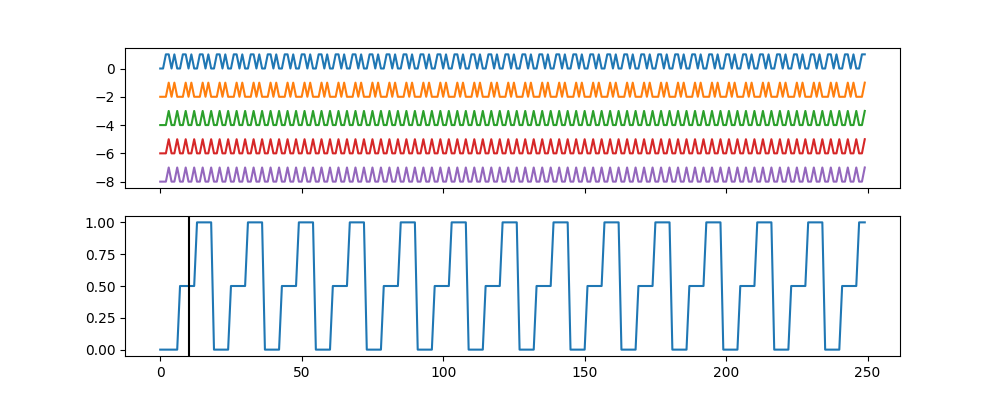

In [15]:
low_lim, high_lim = 0, 250
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 4)) # plt.sca(axes)
ax[0].plot(gestures_protocol[['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']][low_lim:high_lim].values - np.arange(5) * 2)
ax[1].plot(gestures_protocol[['Pronation']][low_lim:high_lim].values)
# Для примера сравним сигналы в рйоне 6 периода
plt.axvline(10, color='k', label='Train-Test split')
plt.show()

In [16]:
# add OPEN to protocol
mask_open = (gestures_protocol[['Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch']] == 1.0).all(axis=1)
gestures_protocol.loc[mask_open, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']] = -0.5

In [17]:
gestures_protocol.loc[mask_open, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']] = -0.5

In [18]:
# Смотрим все признаки вместе (для информации) 
gestures_train_ext = pd.merge(
    gestures_train,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext = pd.merge(
    gestures_test,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)
gestures_train_ext.head()

,0,1,2,3,4,5,6,7,8,9,...,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
0,0,0,69,3461,3694,3418,1867,13,7,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,11,58,3462,3692,3417,1868,13,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,8,51,3463,3693,3418,1870,21,6,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,9,58,3463,3692,3418,1871,13,6,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,8,58,3460,3692,3418,1869,13,6,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
gestures_train_ext.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts', 'Thumb',
       'Index', 'Middle', 'Ring', 'Pinky', 'Thumb_stretch', 'Index_stretch',
       'Middle_stretch', 'Ring_stretch', 'Pinky_stretch', 'Pronation'],
      dtype='object')

In [20]:
gestures_test.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [21]:
gestures_train['ts'].head()

0    161790
1    161823
2    161856
3    161889
4    161922
Name: ts, dtype: int64

In [22]:
Pronat = pd.get_dummies(gestures_protocol['Pronation'], prefix='Pronation')
gestures_protocol = pd.concat([gestures_protocol, Pronat], axis=1)
gestures_protocol.drop(['Pronation'], axis=1, inplace=True)

# Features list
PRON = ['Pronation_0.0', 'Pronation_0.5', 'Pronation_1.0']

gestures_protocol.head(2)

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation_0.0,Pronation_0.5,Pronation_1.0
epoch,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


In [23]:
gestures_protocol.shape

(307, 13)

In [24]:
gestures_train.shape

(21320, 65)

In [25]:
gestures_train[['SYNC']]

,SYNC
0,0
1,0
2,0
3,0
4,0
...,...
21315,173
21316,173
21317,173
21318,173


## Composition of X_train

In [26]:
gestures_train[OMG_CH + GYR_CH + ACC_CH ]

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,GYR0,GYR1,GYR2,ACC0,ACC1,ACC2
0,0,0,69,3461,3694,3418,1867,13,7,7,...,12,14,29,27,95,-12,-8,-12,-22,85
1,0,11,58,3462,3692,3417,1868,13,7,5,...,11,14,29,26,93,-10,-1,-10,-22,86
2,10,8,51,3463,3693,3418,1870,21,6,6,...,5,14,28,25,92,-11,4,-11,-23,84
3,11,9,58,3463,3692,3418,1871,13,6,6,...,10,14,26,24,90,-8,6,-11,-22,85
4,11,8,58,3460,3692,3418,1869,13,6,5,...,11,14,26,24,88,-7,7,-10,-22,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21315,6,8,55,3375,3829,3831,2273,11,6,5,...,10,14,25,24,103,-23,-1,-6,-27,92
21316,11,8,56,3368,3837,3827,2261,11,7,4,...,10,13,24,23,107,-20,-1,-7,-28,91
21317,10,7,53,3347,3846,3820,2238,10,6,5,...,10,13,25,22,104,-21,-2,-6,-31,89
21318,11,8,50,3317,3853,3821,2162,9,6,6,...,10,12,25,23,96,-24,0,-6,-31,91


In [32]:
X_train_raw, X_test_raw = gestures_train[OMG_CH].values, gestures_test[OMG_CH].values #56
# Предобработка скользящим окном
#X_train, X_test = X_train.rolling(window=3).mean().dropna(axis=0), X_test.rolling(window=3).mean().dropna(axis=0)

display('X_train', pd.DataFrame(X_train_raw, columns=OMG_CH).head(2))

y_train, y_test = gestures_train[GLOVE_CH].values, gestures_test[GLOVE_CH].values

# Предобработка скользящим окном
#y_train, y_test =  y_train.iloc[2:,:], y_test.iloc[2:,]
display('y_train', pd.DataFrame(y_train).head(2) )#'y_test', y_test.head(2)

'X_train'

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,69,3461,3694,3418,1867,13,7,7,...,43,30,5,14,2,9,12,14,29,27
1,0,11,58,3462,3692,3417,1868,13,7,5,...,45,29,17,14,16,10,11,14,29,26


'y_train'

,0,1,2,3,4
0,13,34,48,35,32
1,13,34,48,35,32


In [ ]:
get_signals_plot(X_train_raw, y_train, 'Protocol gestures')

In [29]:
#X_free, y_free = free_movements.iloc[:,0:50], free_movements[GLOVE_CH]

#display(X_free.head(2),'X_free', X_free.shape, y_free.head(2),y_free.shape)

In [30]:
#get_signals_plot(X_free, y_free, 'Free signals')

# Preprocessing

In [37]:
# Smoothing of sensor signals
X_train = np.transpose([savgol_filter(X_train_raw[:,i], window_length=14, polyorder=2) for i in range(X_train_raw.shape[1])]) 
X_test = np.transpose([savgol_filter(X_test_raw[:,i], window_length=14, polyorder=2) for i in range(X_test_raw.shape[1])])

# X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
# X_train.head(1)

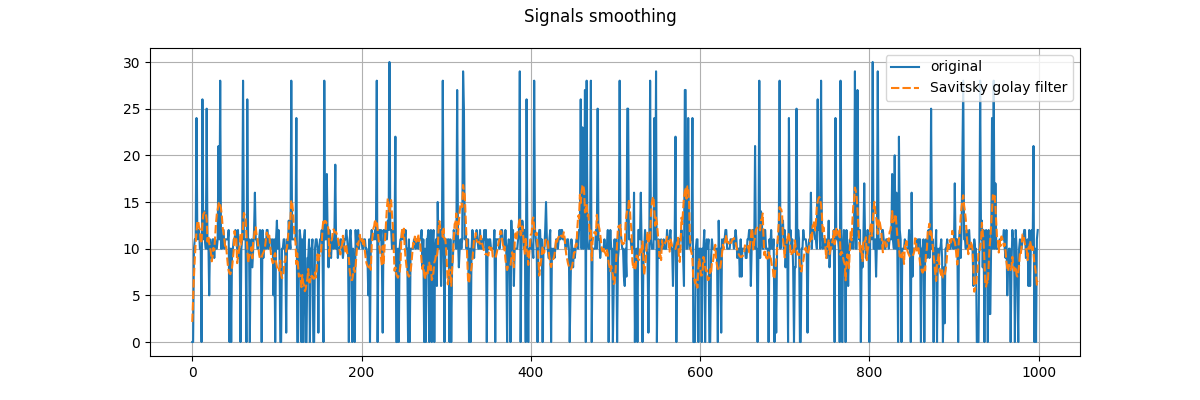

In [32]:
# Smoothing of sensor 0 signal

temp = pd.DataFrame({
    'original':X_train_raw[:1000,0], 
    'Savitsky golay filter':X_train[:1000,0], 
    #'digital filter':X_train.iloc[:,0]
})

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(temp)
plt.suptitle('Signals smoothing')
plt.grid()

In [38]:
# Add differential values
X_train, X_test = add_diff(X_train, shift_=5), add_diff(X_test, shift_=5)

In [39]:
# Scaling values
scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test) 
#display(pd.DataFrame(X_train, columns=COLS).head(1))

# Modeling

### Linear regression

MSE metrics for Test: 
--------


ENC0     97.553283
ENC1     45.108630
ENC2     36.842214
ENC3    102.140901
ENC4     68.196435
dtype: float64

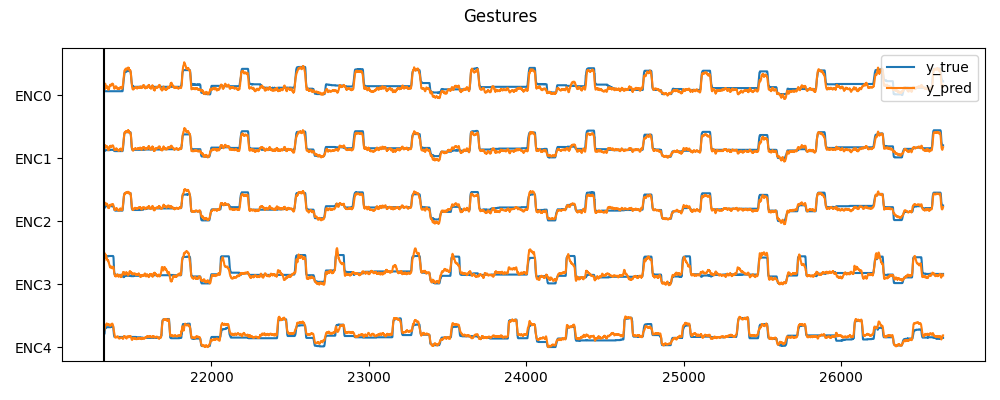

In [40]:
# Creation an instance
lin = LinearRegression()

# Train the Model
lin.fit(X_train, y_train)

# Predict target values
y_pred= pd.DataFrame(lin.predict(X_test), columns=GLOVE_CH, index=gestures_test['ts']).round()

# Display metrics
get_mse(y_test, y_pred)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred, only_test=1)

In [45]:
temp = pd.DataFrame({
    'raw_test':[104.831520, 55.905441, 44.478987, 117.806191, 74.052345],
    'Savgol (15, 2)': [104.106942, 49.561163, 39.139962, 108.748218, 75.875985],
    'add_diff (5)':[97.553283, 45.108630, 36.842214, 102.140901, 68.196435]    
}, index=['ENC0','ENC1','ENC2','ENC3','ENC4']) #, index=GLOVE_CH 

# a['Savitsky-raw'] = (100*(a['raw_test']-a['Savitsky'])/a['raw_test']).round(1)
# a['diff-Savitsky'] = (100*(a['Savitsky']-a['Savitsky_diff'])/a['Savitsky']).round(1)
#a 

temp.round(1)

,без предобработки,"с фильтром Савитского-Галея (15, 2)",c add_diff окно 5
ENC0,104.8,104.1,97.6
ENC1,55.9,49.6,45.1
ENC2,44.5,39.1,36.8
ENC3,117.8,108.7,102.1
ENC4,74.1,75.9,68.2


In [26]:
# Save model to the given path in the pkl format
model_name = 'lin'
full_path = os.path.join(config.PATH_MODEL, model_name + '.pkl')  
 
with open(full_path, 'wb') as f:
    pickle.dump(lin, f)

### Нейронная сеть

In [46]:
reset_random_seeds(seed_value)

#np.expand_dims(X_train, axis=0).shape

n_timesteps = None
b_size = 64
n_channels = X_train.shape[1] # gestures_train[[*OMG_CH, *ACC_CH, *GYR_CH]].shape[1] 
output_units = y_train.shape[1]

# model architecture
input_layer = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LSTM(units=100, 
                         recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3)
                         )(x) 
x = tf.keras.layers.Dropout(0.3)(x) #0.3
output_layer = tf.keras.layers.Dense(units=output_units, activation='elu')(x)

model = tf.keras.Model(
    inputs=input_layer,
    outputs=output_layer,
    name="model_LSTM"
    )

model.summary()

tf.keras.backend.clear_session()

reset_random_seeds(seed_value)

model.compile(
    loss="mean_squared_error", 
    metrics=['mse'], 
    optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=0.001)
    )

callbacks_list = callbacks(1e-04)

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 100)]       0         
                                                                 
 batch_normalization (BatchN  (None, None, 100)        400       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 81,305
Trainable params: 81,105
Non-trainable params: 200
__________________________________________________

In [47]:
history = model.fit(
            x = np.expand_dims(X_train, 1),
            y = y_train,
            batch_size=b_size,
            validation_split=0.2,
            epochs=1500,
            verbose=1,          
            callbacks=callbacks_list
        )
clear_output(wait=False)

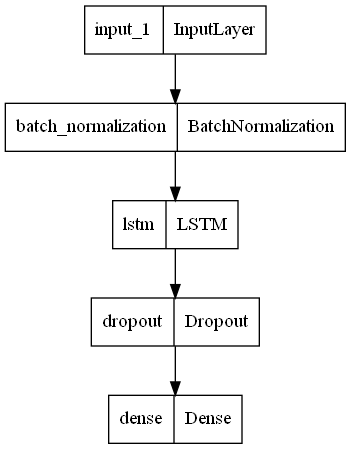

In [ ]:
#plot_model(model)

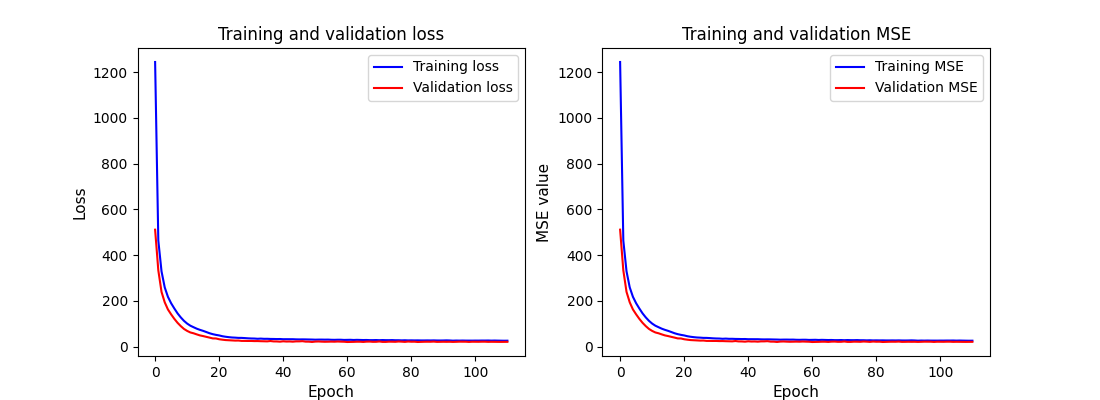

In [48]:
plot_history(history)

## Prediction

167/167 [==============================] - 0s 1ms/step
MSE metrics for Test: 
--------


ENC0    60.403810
ENC1    16.692071
ENC2    17.078372
ENC3    32.817288
ENC4    17.650876
dtype: float64

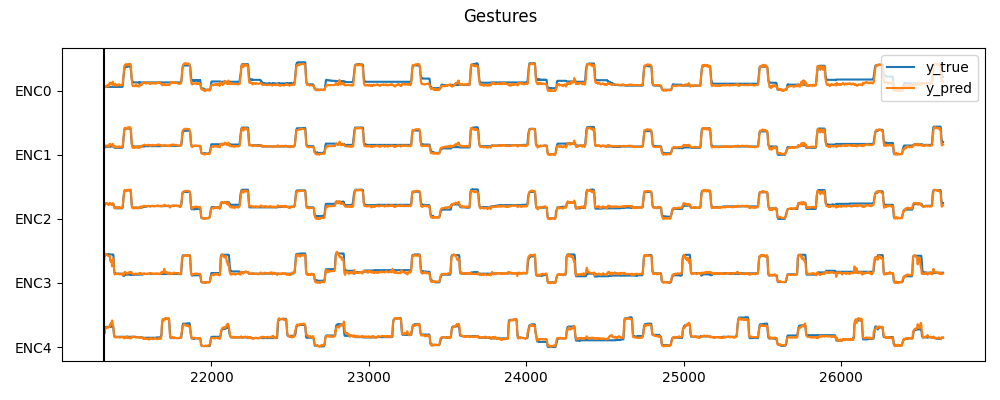

In [49]:
y_pred_train = model.predict(np.expand_dims(X_train, 1)) # [*OMG_CH, *ACC_CH, *GYR_CH] 
y_pred_train = pd.DataFrame(y_pred_train, columns=GLOVE_CH, index=gestures_train['ts'])

y_pred_test = model.predict(np.expand_dims(X_test, 1)) #[*OMG_CH, *ACC_CH, *GYR_CH]
y_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test['ts'])

# Display metrics
get_mse(y_test, y_pred_test)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred_test, only_test=1)

> Метрики нейронной сети Со сглаживанием и diff:
``` Python
ENC0    60.403810
ENC1    16.692071
ENC2    17.078372
ENC3    32.817288
ENC4    17.650876
```

## Postprocessing

In [55]:
preproc_coef = 0.57

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    return y

# пропускаем нулевой элемент
y_pred_test_proc = np.zeros_like(y_pred_test)
y_pred_test_proc[0] = y_pred_test.iloc[0]


for i in range(1, len(y_pred_test)):
    y_pred_test_proc[i] = postprocessing(y_pred_test.iloc[i], y_pred_test.iloc[i-1])

# округление
y_pred_test_proc = pd.DataFrame(y_pred_test_proc, columns = [GLOVE_CH]).round() # или np.rint()

# преобразование значений в заданный диапазон 
y_pred_test_proc = np.round(np.clip(y_pred_test_proc, 0, 100)) 

# Display metrics
get_mse(y_test, y_pred_test_proc)

MSE metrics for Test: 
--------


ENC0    60.002814
ENC1    16.773171
ENC2    17.282739
ENC3    31.555722
ENC4    17.410507
dtype: float64

> Метрики нейронной сети Со сглаживанием и diff:
``` Python
ENC0    60.403810
ENC1    16.692071
ENC2    17.078372
ENC3    32.817288
ENC4    17.650876
```
> Метрики нейронной сети с постобработкой:
``` Python
ENC0    60.002814
ENC1    16.773171
ENC2    17.282739
ENC3    31.555722
ENC4    17.410507
```

In [54]:
y_pred_test_proc

,ENC0,ENC1,ENC2,ENC3,ENC4
0,9.0,22.0,40.0,74.0,54.0
1,10.0,23.0,42.0,80.0,53.0
2,11.0,25.0,44.0,86.0,53.0
3,12.0,26.0,46.0,89.0,54.0
4,12.0,27.0,47.0,90.0,55.0
...,...,...,...,...,...
5325,26.0,31.0,40.0,30.0,29.0
5326,26.0,31.0,41.0,30.0,30.0
5327,27.0,31.0,41.0,30.0,30.0
5328,27.0,32.0,41.0,30.0,30.0


In [57]:
# y_pred_train = np.where(y_pred_train < 0, 0, y_pred_train) 
# y_pred_train = np.where(y_pred_train > 100, 100, y_pred_train) 
# y_pred_test = np.where(y_pred_test < 0, 0, y_pred_test)
# y_pred_test = np.where(y_pred_test > 100, 100, y_pred_test)

# # Display metrics
# get_mse(y_test, pd.DataFrame(y_pred_test,columns=GLOVE_CH), y_train, pd.DataFrame(y_pred_train, columns=GLOVE_CH))

MSE metrics for Train: 
--------


ENC0     5.986020
ENC1     5.413849
ENC2     6.979174
ENC3     8.145156
ENC4    12.701870
dtype: float64

MSE metrics for Test: 
--------


ENC0    22.238066
ENC1    23.113186
ENC2    22.323589
ENC3    37.002370
ENC4    59.285329
dtype: float64

# Real-time inference

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils

In [ ]:
def preprocessing(x):
    # x - sample vector
    y = np.transpose([savgol_filter(x[:,i], window_length=60, polyorder=4) for i in range(x.shape[1])])
    
    # Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    y = scaler.fit_transform(y)
    
    # add_differential values
    y = add_diff(y, shift_=5)
    return y

X_train, X_test = preprocessing(X_train), preprocessing(X_test)

x = X_train

def inference(x:pd.DataFrame, saved_model=tf.keras.models.load_model(os.path.join(config.PATH_MODEL+'best_model.hdf5')))->pd.DataFrame:
    """_summary_

    Args:
        x (pd.DataFrame): _description_
        saved_model (keras.engine.functional.Functional): model

    Returns:
        _type_: _description_
    """
    print(saved_model.summary())
    
    y = np.expand_dims(x, 1)
    y = saved_model.predict([y])#[0] 
    return y

y_pred_test=inference(X_test)
#y_pred_test=pd.DataFrame(y_pred_test, columns=GLOVE_CH) ## index=gestures_test['ts']
# Display metrics
#get_mse(y_test, y_pred_test)


def postprocessing(x, prev, preproc_coef=0.57):
    if prev is None:
        y = x
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    return y


# пропускаем нулевой элемент
y_pred_test_proc = np.zeros_like(y_pred_test)
y_pred_test_proc[0] = y_pred_test.iloc[0]


for i in range(1, len(y_pred_test)):
    y_pred_test_proc[i] = postprocessing(y_pred_test.iloc[i], y_pred_test.iloc[i-1])

y_pred_test_proc = pd.DataFrame(y_pred_test_proc, columns = [GLOVE_CH])

y_pred_test_proc = np.round(np.clip(y_pred_test_proc, 0, 100)) 

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Эмуляция

In [70]:
df_sim = gestures_test.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(8168, 65)


In [71]:
TIMEOUT = 0.033
DEBUG = True

ts_list = [] 
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
omg_previous = None # эту переменную добавил для "супер умного" препроцессинга, в иделае тут всякие сглаживатели бы накрутить


y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed, y_previous)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    
  
    # [/Data logging]

    y_previous = y_postprocessed # для сглаживания 
    omg_previous = omg_sample # просто чтобы была
    
    ts_list.append(ts_diff) # проверю времена выполнения
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

NameError: name 'preprocessing' is not defined

## Inference

### Offline (dataset)

In [64]:
df_sim = gestures_test.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

TIMEOUT = 0.033
DEBUG = True
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

(8168, 65)


NameError: name 'preprocessing' is not defined

In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8168, 50)
enc_sample.shape = (8168, 6)
sample_preprocessed.shape = (8168, 50)
y_predicted.shape = (8168, 6)
y_postprocessed.shape = (8168, 6)
y_commands.shape = (8168, 6)


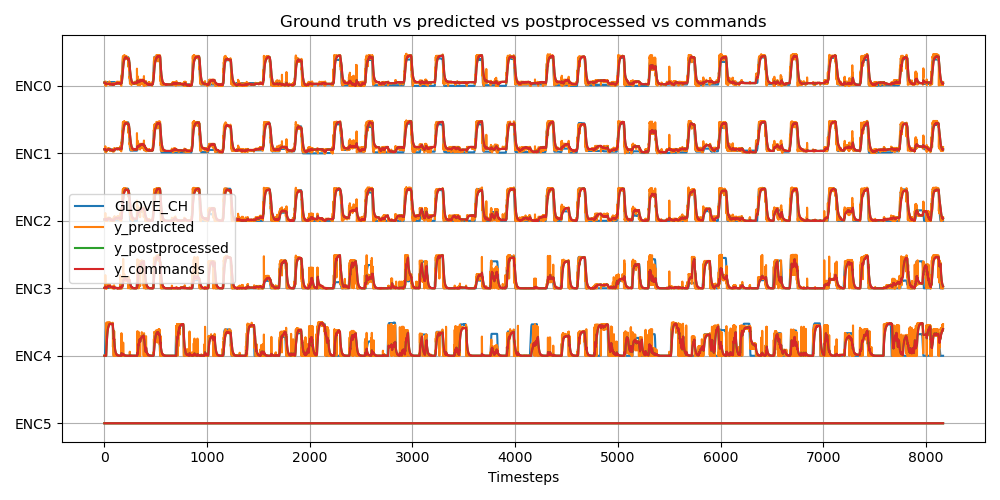

In [ ]:
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 